# Beta Bank 

## Introduction

In the dynamic retail banking landscape, customer retention holds paramount importance for sustained growth and profitability. Beta Bank is witnessing a concerning trend: a gradual erosion of its customer base, leading to a significant impact on its financial performance. Recognizing the urgency of the situation, the bank has launched a project aimed at developing a predictive model capable of anticipating customer churn.

The objective of this project is to utilize historical data on customer behavior and termination patterns to forecast the likelihood of customer attrition in the near future. By accurately identifying at-risk customers, Beta Bank can proactively implement retention strategies to safeguard its customer base and optimize operational efficiency.

The primary performance metric for evaluating this predictive model is the F1 score, with a minimum threshold of 0.59 required for project approval. The F1 score, striking a balance between precision and recall, ensures reliable churn identification.

Additionally, the model's performance will be assessed using the AUC-ROC (Area Under the Receiver Operating Characteristic curve) metric. A high AUC-ROC value indicates the model's effectiveness in distinguishing between churn and non-churn instances across various decision thresholds.

Through this project, the goal is to deliver a robust predictive tool that empowers Beta Bank to preemptively address customer churn, fostering enduring customer relationships and sustaining the bank's competitive edge in the market. This initiative represents a strategic step towards enhancing Beta Bank's operational resilience and ensuring long-term success in the evolving banking landscape.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils import shuffle, resample

pd.options.mode.chained_assignment = None

In [2]:
try:
    columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']
    data = pd.read_csv('../data/Churn.csv', header=0, names=columns)
except FileNotFoundError as e:
    print(f"The error ({e}) occured while trying to load the data")
else:
    print(f"The data was loaded successfully!")

The data was loaded successfully!


## Data Preparation

In [3]:
data.shape

(10000, 14)

In [4]:
# Look at data types and missing values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


The columns have the appropriate data types, although it appears that the tenure column contains missing values. The missing values will be filled using the median, because of the wide range of values. 

In [5]:
num_duplicated = data.duplicated().sum()
num_missing = data['tenure'].isna().sum()

print(f"Number of duplicated values: {num_duplicated}\nNumber of missing values in 'tenure' column: {num_missing}")

Number of duplicated values: 0
Number of missing values in 'tenure' column: 909


In [6]:
# Observe random sample of the rows with missing values in 'tenure' col

data[data['tenure'].isna()].sample(10)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
4983,4984,15723721,Tinline,543,France,Male,30,NaN,140916.81,1,1,0,157711.18,0
5427,5428,15674149,Esomchi,599,Germany,Male,36,NaN,128960.21,2,1,1,40318.33,0
3739,3740,15801125,Kegley,627,France,Female,32,NaN,0.00,1,1,0,106851.70,0
5038,5039,15589230,Wu,612,France,Female,63,NaN,126473.33,1,0,1,147545.65,0
4974,4975,15744942,Steele,638,Spain,Female,55,NaN,155828.22,1,0,1,108987.25,1
8630,8631,15786042,Willmore,706,Germany,Female,44,NaN,185932.18,2,1,0,65413.41,0
7053,7054,15815271,Ritchie,755,Germany,Male,43,NaN,165048.50,3,1,0,16929.41,1
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0
4448,4449,15708162,Thomson,565,Germany,Female,40,NaN,89994.71,2,0,1,121084.27,0
6985,6986,15586699,Thomson,825,France,Male,32,NaN,0.00,2,0,0,9751.03,0


In [7]:
# Observe random sample of the rows WITHOUT missing values in 'tenure' col

data[data['tenure'] != 'NaN'].sample(10)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2175,2176,15769254,Tuan,757,Germany,Female,34,9.0,101861.36,2,0,0,187011.96,0
4079,4080,15694601,Ankudinov,583,France,Female,31,NaN,158978.79,1,1,0,12538.92,0
4130,4131,15731669,Szabados,554,France,Male,39,2.0,129709.62,1,1,0,173197.12,0
9819,9820,15813946,Duffy,637,Germany,Male,51,1.0,104682.83,1,1,0,55266.96,1
2611,2612,15746564,O'Sullivan,566,France,Male,42,3.0,108010.78,1,1,1,157486.10,0
7468,7469,15627328,Millar,542,Spain,Female,26,2.0,0.00,2,1,1,54869.54,0
8528,8529,15636353,Buchi,534,Spain,Male,35,4.0,0.00,2,0,0,9541.15,0
1424,1425,15596671,Endrizzi,603,Spain,Female,42,8.0,91611.12,1,0,0,144675.30,1
4364,4365,15727408,Koo,523,Germany,Male,27,8.0,61688.61,2,1,0,147059.16,0
485,486,15637954,Lewis,730,France,Female,35,0.0,155470.55,1,1,1,53718.28,0


In [8]:
# Fill missing values with median
median_value = data['tenure'].median()
data['tenure'].fillna(median_value, inplace=True)

# Reprint number of missing values
num_missing = data['tenure'].isna().sum()
print(f"Number of missing values in 'tenure' column: {num_missing}")

Number of missing values in 'tenure' column: 0


## Feature Preparation

In [9]:
# Drop rows that will not be relevant to the model

data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [10]:
# Find unique values in 'gender' col
gen_unique = data['gender'].unique()

# Find unique values in 'geography' col
geo_unique = data['geography'].unique()

print(f"Unique values in the geography column:{geo_unique}\nUnique values in the gender column:{gen_unique}")

Unique values in the geography column:['France' 'Spain' 'Germany']
Unique values in the gender column:['Female' 'Male']


The geography and gender columns are of the object data type, which will not work with machine learning. These values need to be converted to a numerical value, using one-hot encoding that can be used in machine learning. 

In [11]:
# Grab columns with 'object' data type
object_cols = data.select_dtypes(include=['object']).columns

data = pd.get_dummies(data, columns=object_cols, drop_first=True)

Since only one dataset is available, the source data will be divided into a split of 3:1:1. This allocation designates 60% of the data for training, while 20% is reserved for both validation and testing purposes.

In [12]:
# Function to split data into 3:1:1 ratio and return the three datasets

def split_data_3_1_1(dataset, test_s=0.40, rnd_state=42, shuffle=True):
    '''Prints a statement specifying the data-split used and returns 3 variables for the train, validation and test datasets respectively'''
    
    # Splitting the source data into 40% for Validation (to be split again) and 60% for Training
    df_train, df_valid = train_test_split(dataset, test_size=test_s, shuffle=True, random_state=rnd_state)

    # Further splitting the df_valid data 50/50 (40% from previous task) to obtain 3:1:1 ratio
    df_test, df_valid = train_test_split(df_valid, test_size=(test_s + .10), shuffle=True, random_state=rnd_state)
    
    # Printing confirmation of data split
    sum_of_datasets = len(df_train) + len(df_valid) + len(df_test)
    if len(data) == sum_of_datasets:
        print(f"Data split ratio is 3:1:1, where data split is allocated as:\nTraining = 60% [shape={df_train.shape}]\nValidation = 20% [shape={df_valid.shape}]\nTesting = 20% [shape={df_test.shape}]")
    
    return df_train, df_valid, df_test


# Function to declare the features and target from dataset
def prepare_data(dataset, drop_cols, target_col):
    '''Returns the features and target for a given dataset'''
    features = dataset.drop(drop_cols, axis=1)
    target = dataset[target_col]
    
    return features, target

In [13]:
# Create train, validation and test dataset
df_train, df_valid, df_test = split_data_3_1_1(data, 0.40, 24681)

# Declare the train, validation, and test features & target
train_features, train_target = prepare_data(df_train, ['exited'], 'exited')
valid_features, valid_target = prepare_data(df_valid, ['exited'], 'exited')
test_features, test_target = prepare_data(df_test, ['exited'], 'exited')

Data split ratio is 3:1:1, where data split is allocated as:
Training = 60% [shape=(6000, 12)]
Validation = 20% [shape=(2000, 12)]
Testing = 20% [shape=(2000, 12)]


In [14]:
# Observe the train dataset

df_train.head(5)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
8384,755,34,3.0,0.00,2,1,1,158816.03,0,False,False,True
2187,699,34,8.0,0.00,1,1,1,76510.46,0,False,True,True
2974,565,59,9.0,69129.59,1,1,1,170705.53,0,True,False,True
4760,850,40,1.0,76914.21,1,1,0,174183.44,0,False,False,True
9814,631,36,1.0,0.00,2,0,0,133141.34,0,False,False,True


In [15]:
# Observe the validation dataset

df_valid.head(5)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
1892,634,31,8.0,76798.92,1,0,0,196021.73,0,True,False,False
6724,752,41,8.0,0.00,2,1,0,139844.04,1,False,False,False
1558,571,35,1.0,104783.81,2,0,1,178512.52,0,False,False,False
7100,650,24,5.0,108881.73,1,1,0,104492.83,0,False,True,True
329,664,26,5.0,116244.14,2,1,1,95145.14,0,True,False,True


In [16]:
# Observe the test dataset

df_test.head(5)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
9254,686,32,6.0,0.00,2,1,1,179093.26,0,False,False,True
5088,543,42,4.0,89838.71,3,1,0,85983.54,1,False,False,True
2516,814,36,6.0,0.00,2,1,1,98657.01,0,False,False,False
1834,700,46,5.0,56580.95,2,0,1,45424.13,0,False,True,False
622,535,53,5.0,141616.55,2,1,1,75888.65,0,True,False,False


The numeric columns in the datasets exhibit a diverse range of values. The credit_score, age, tenure, balance, num_of_products, and estimated_salary columns all display a wide spectrum of values. To address this variability, these columns require standardization using a scaler.

In [17]:
# Fit the features on the three datasets
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler = StandardScaler()

scaler.fit(train_features[numeric])

train_features[numeric] = scaler.transform(train_features[numeric])
valid_features[numeric] = scaler.transform(valid_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

In [18]:
# Re-examine the features after sclaing
valid_features.head(5)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
1892,-0.170053,-0.746397,1.074465,0.001407,-0.904524,0,0,1.678152,True,False,False
6724,1.061746,0.194202,1.074465,-1.236040,0.833831,1,0,0.701775,False,False,False
1558,-0.827708,-0.370157,-1.453547,0.452322,0.833831,0,1,1.373839,False,False,False
7100,-0.003029,-1.404817,-0.008968,0.518351,-0.904524,1,0,0.087366,False,True,True
329,0.143117,-1.216697,-0.008968,0.636980,0.833831,1,1,-0.075098,True,False,True


In [19]:
# Create function to calculate common classification metrics

def calculate_classification_metrics(y_true, y_pred):
    '''Calculates and returns basic evaluation metrics for classification tasks'''
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy: {round(accuracy, 4)}")
    print(f"Recall: {round(recall, 4)}")
    print(f"Precision: {round(precision, 4)}")
    print(f"F1 Score: {round(f1, 4)}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    return accuracy, recall, precision, conf_matrix, f1

## Initial Training (Unbalanced)

### Decision Tree Classification (Unbalanced)

In [20]:
# Find the best conditions

best_model = None
best_result = 0
best_depth = 0

for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=24681, max_depth=depth)
    model.fit(train_features, train_target)
    valid_predictions = model.predict(valid_features)
    result = accuracy_score(valid_target, valid_predictions) 
    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print(f"Accuracy of the best model: {best_result}\nDepth of the best model: {best_depth}")

Accuracy of the best model: 0.8595
Depth of the best model: 7


In [21]:
# Test the model using validation data

model = DecisionTreeClassifier(random_state=24681, max_depth=7)
model.fit(train_features, train_target)
valid_predictions = model.predict(valid_features)

print(f"Tree Classifier Scores (Unbalanced):")
accuracy, recall, precision, conf_matrix, f1 = calculate_classification_metrics(valid_target, valid_predictions)

Tree Classifier Scores (Unbalanced):
Accuracy: 0.8595
Recall: 0.4917
Precision: 0.7555
F1 Score: 0.5957
Confusion Matrix:
[[1512   67]
 [ 214  207]]


### Random Forest Classification (Unbalanced)

In [22]:
# Find the best conditions

best_model_forest = None
best_result_forest = 0
best_est_forest = 0

for est in range(1, 20):
    model = RandomForestClassifier(random_state=24681, n_estimators=est)
    model.fit(train_features, train_target)
    valid_predictions = model.predict(valid_features)
    result = accuracy_score(valid_target, valid_predictions) 
    if result > best_result_forest:
        best_model_forest = model
        best_result_forest = result
        best_est_forest = est
        
print(f"Accuracy of the best model: {best_result_forest}\nNumber of estimators of the best model: {est}")

Accuracy of the best model: 0.855
Number of estimators of the best model: 19


In [23]:
# Test the model using validation data

model = RandomForestClassifier(random_state=24681, n_estimators=19)
model.fit(train_features, train_target)
valid_predictions = model.predict(valid_features)

print(f"Random Forest Classification Scores (Unbalanced):")
accuracy, recall, precision, conf_matrix, f1 = calculate_classification_metrics(valid_target, valid_predictions)

Random Forest Classification Scores (Unbalanced):
Accuracy: 0.8535
Recall: 0.5036
Precision: 0.7162
F1 Score: 0.5914
Confusion Matrix:
[[1495   84]
 [ 209  212]]


### Logisitic Regression Classification (Unbalanced)

In [24]:
# Find the best conditions

model = LogisticRegression(random_state=24681, solver='liblinear')
model.fit(train_features, train_target) 
valid_predictions = model.predict(valid_features)
result = accuracy_score(valid_target, valid_predictions)

print(f"Accuracy of the best model: {result}")

Accuracy of the best model: 0.8125


In [25]:
# Test the model using validation data

model = LogisticRegression(random_state=24681, solver='liblinear')
model.fit(train_features, train_target) 
valid_predictions = model.predict(valid_features)

print(f"Logisitic Regression Classification Scores (Unbalanced):")
accuracy, recall, precision, conf_matrix, f1 = calculate_classification_metrics(valid_target, valid_predictions)

Logisitic Regression Classification Scores (Unbalanced):
Accuracy: 0.8125
Recall: 0.228
Precision: 0.6575
F1 Score: 0.3386
Confusion Matrix:
[[1529   50]
 [ 325   96]]


## Class Imbalance Observations

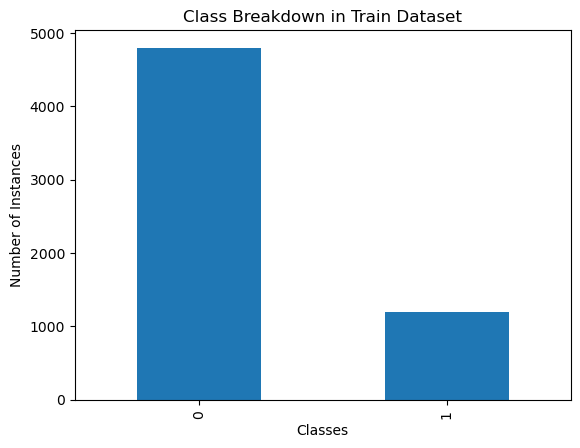

In [26]:
# Look for imbalance in train data
train_class_split = train_target.value_counts()

train_class_split.plot(kind='bar', title='Class Breakdown in Train Dataset', xlabel='Classes', ylabel='Number of Instances')
plt.show()

It is apparent that there is a notable class imbalance in the training dataset. The minority class should be upsampled to amplify its signal within the training dataset. Additionally, setting the class weights to balanced will enable the model to treat the classes equally during training.

### Upsampling

In [27]:
# Function to upsample 

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    return shuffle(features_upsampled, target_upsampled, random_state=24681)

In [28]:
# Upsample the data

train_features_upsampled, train_target_upsampled = upsample(train_features, train_target, 6)

In [29]:
# Observe new feature data

train_features_upsampled.shape

(12005, 11)

In [30]:
# Observe new target data

train_target_upsampled.shape

(12005,)

## Initial Training (Balanced)

### Decision Tree Classification (Balanced - Class Weights)

In [31]:
# Find the best conditions

best_model = None
best_result = 0
best_depth = 0

for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=24681, max_depth=depth, class_weight='balanced')
    model.fit(train_features, train_target)
    valid_predictions = model.predict(valid_features)
    result = accuracy_score(valid_target, valid_predictions) 
    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print(f"Accuracy of the best model: {best_result}\nDepth of the best model: {best_depth}")

Accuracy of the best model: 0.7895
Depth of the best model: 5


In [32]:
# Test the model using validation data

model = DecisionTreeClassifier(random_state=24681, max_depth=20, class_weight='balanced')
model.fit(train_features, train_target)
valid_predictions = model.predict(valid_features)

print(f"Tree Classifier Scores (Unbalanced):")
accuracy, recall, precision, conf_matrix, f1 = calculate_classification_metrics(valid_target, valid_predictions)

Tree Classifier Scores (Unbalanced):
Accuracy: 0.789
Recall: 0.5297
Precision: 0.4989
F1 Score: 0.5138
Confusion Matrix:
[[1355  224]
 [ 198  223]]


### Decision Tree Classification (Balanced - Upsampling)

In [33]:
# Find the best conditions

best_model = None
best_result = 0
best_depth = 0

for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=24681, max_depth=depth)
    model.fit(train_features_upsampled, train_target_upsampled)
    valid_predictions = model.predict(valid_features)
    result = accuracy_score(valid_target, valid_predictions) 
    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print(f"Accuracy of the best model: {best_result}\nDepth of the best model: {best_depth}")

Accuracy of the best model: 0.7925
Depth of the best model: 18


In [34]:
# Test the model using validation data

model = DecisionTreeClassifier(random_state=24681, max_depth=19)
model.fit(train_features_upsampled, train_target_upsampled)
valid_predictions = model.predict(valid_features)

print(f"Tree Classifier Scores (Balanced using Class Weight):")
accuracy, recall, precision, conf_matrix, f1 = calculate_classification_metrics(valid_target, valid_predictions)

Tree Classifier Scores (Balanced using Class Weight):
Accuracy: 0.788
Recall: 0.5202
Precision: 0.4966
F1 Score: 0.5081
Confusion Matrix:
[[1357  222]
 [ 202  219]]


### Random Forest Classification (Balanced - Class Weights)

In [35]:
# Find the best conditions

best_model_forest = None
best_result_forest = 0
best_est_forest = 0

for est in range(1, 20):
    model = RandomForestClassifier(random_state=24681, n_estimators=est, class_weight='balanced')
    model.fit(train_features, train_target)
    valid_predictions = model.predict(valid_features)
    result = accuracy_score(valid_target, valid_predictions) 
    if result > best_result_forest:
        best_model_forest = model
        best_result_forest = result
        best_est_forest = est
        
print(f"Accuracy of the best model: {best_result_forest}\nNumber of estimators of the best model: {est}")

Accuracy of the best model: 0.8575
Number of estimators of the best model: 19


In [36]:
# Test the model using validation data

model = RandomForestClassifier(random_state=24681, n_estimators=19, class_weight='balanced')
model.fit(train_features, train_target)
valid_predictions = model.predict(valid_features)

print(f"Random Forest Classification Scores (Balanced):")
accuracy, recall, precision, conf_matrix, f1 = calculate_classification_metrics(valid_target, valid_predictions)

Random Forest Classification Scores (Balanced):
Accuracy: 0.855
Recall: 0.4869
Precision: 0.7348
F1 Score: 0.5857
Confusion Matrix:
[[1505   74]
 [ 216  205]]


### Random Forest Classification (Balanced - Upsampling)

In [37]:
# Find the best conditions

best_model_forest = None
best_result_forest = 0
best_est_forest = 0

for est in range(1, 20):
    model = RandomForestClassifier(random_state=24681, n_estimators=est)
    model.fit(train_features_upsampled, train_target_upsampled)
    valid_predictions = model.predict(valid_features)
    result = accuracy_score(valid_target, valid_predictions) 
    if result > best_result_forest:
        best_model_forest = model
        best_result_forest = result
        best_est_forest = est
        
print(f"Accuracy of the best model: {best_result_forest}\nNumber of estimators of the best model: {est}")

Accuracy of the best model: 0.8545
Number of estimators of the best model: 19


In [38]:
# Test the model using validation data

model = RandomForestClassifier(random_state=24681, n_estimators=19)
model.fit(train_features_upsampled, train_target_upsampled)
valid_predictions = model.predict(valid_features)

print(f"Random Forest Classification Scores (Balanced):")
accuracy, recall, precision, conf_matrix, f1 = calculate_classification_metrics(valid_target, valid_predictions)

Random Forest Classification Scores (Balanced):
Accuracy: 0.8495
Recall: 0.6081
Precision: 0.6531
F1 Score: 0.6298
Confusion Matrix:
[[1443  136]
 [ 165  256]]


### Logisitic Regression Classification (Balanced - Class Weights)

In [39]:
# Find the best conditions

model = LogisticRegression(random_state=24681, solver='liblinear', class_weight='balanced')
model.fit(train_features, train_target) 
valid_predictions = model.predict(valid_features)
result = accuracy_score(valid_target, valid_predictions)

print(f"Accuracy of the best model: {result}")

Accuracy of the best model: 0.716


In [40]:
# Test the model using validation data

model = LogisticRegression(random_state=24681, solver='liblinear', class_weight='balanced')
model.fit(train_features, train_target) 
valid_predictions = model.predict(valid_features)

print(f"Logisitic Regression Classification Scores (Balanced):")
accuracy, recall, precision, conf_matrix, f1 = calculate_classification_metrics(valid_target, valid_predictions)

Logisitic Regression Classification Scores (Balanced):
Accuracy: 0.716
Recall: 0.7102
Precision: 0.4013
F1 Score: 0.5129
Confusion Matrix:
[[1133  446]
 [ 122  299]]


### Logisitic Regression Classification (Balanced - Upsampling)

In [41]:
# Find the best conditions

model = LogisticRegression(random_state=24681, solver='liblinear')
model.fit(train_features_upsampled, train_target_upsampled) 
valid_predictions = model.predict(valid_features)
result = accuracy_score(valid_target, valid_predictions)

print(f"Accuracy of the best model: {result}")

Accuracy of the best model: 0.608


In [42]:
# Test the model using validation data

model = LogisticRegression(random_state=24681, solver='liblinear')
model.fit(train_features_upsampled, train_target_upsampled) 
valid_predictions = model.predict(valid_features)

print(f"Logisitic Regression Classification Scores (Balanced):")
accuracy, recall, precision, conf_matrix, f1 = calculate_classification_metrics(valid_target, valid_predictions)

Logisitic Regression Classification Scores (Balanced):
Accuracy: 0.608
Recall: 0.8076
Precision: 0.326
F1 Score: 0.4645
Confusion Matrix:
[[876 703]
 [ 81 340]]


## Observations

After conducting training experiments with and without balanced classes, it is evident that the model achieves its best performance when trained on upsampled data. Among the models tested, the Random Forest Model consistently delivered superior results, exhibiting the highest F1 score, and other key metrics under these conditions.

In order to ensure that the model reaches the target f1 score, the final model will be trained using balanced classes and upsampled data.

## Final Testing

In [43]:
# Test the final modal

model = RandomForestClassifier(random_state=24681, n_estimators=19, class_weight='balanced')
model.fit(train_features_upsampled, train_target_upsampled)
test_predictions = model.predict(test_features) # Use test features, previously completely unused

print(f"Random Forest Classification Scores (Final):")
accuracy, recall, precision, conf_matrix, f1 = calculate_classification_metrics(test_target, test_predictions)

Random Forest Classification Scores (Final):
Accuracy: 0.8405
Recall: 0.5759
Precision: 0.6257
F1 Score: 0.5997
Confusion Matrix:
[[1442  143]
 [ 176  239]]


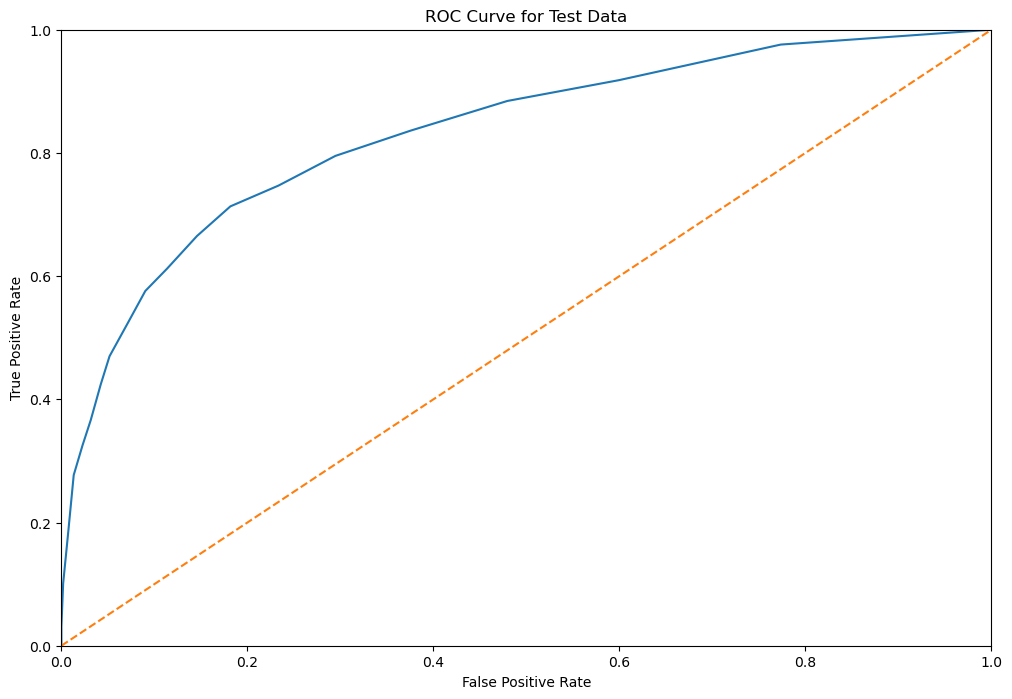

The ROC-AUC score final model: 0.833


In [44]:
# Plot the ROC Curve
probabilities_test = model.predict_proba(test_features)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_test)
auc_score = roc_auc_score(test_target, probabilities_one_test)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve for Test Data")
plt.show()

print(f"The ROC-AUC score final model: {round(auc_score, 4)}")

The final model was trained using upsampled data with balanced classes, which were identified as the optimal conditions for training. The model was then tested using previously unused testing features and targets. During testing, the model achieved an accuracy of 84.2%, with a recall of 57.5% and a precision of 62.5%. These metrics indicate that the model performs above average and is precise in identifying true positives.

Furthermore, the F1 score for the model stands at 59.9%, demonstrating a balanced performance between precision and recall. Additionally, the model has an area under the ROC curve (AUC-ROC) of 83.3%, indicating its ability to distinguish between positive and negative instances across various thresholds.

## Conclusion

The goal of this project was to utilize historical customer behavior and termination patterns to predict the likelihood of customer attrition. By accurately identifying at-risk customers, Beta Bank can proactively implement retention strategies to safeguard its customer base and optimize operational efficiency.

The primary performance metrics used to evaluate the predictive model included the F1 score, which balances precision and recall to ensure reliable churn identification, and the AUC-ROC metric, which measures the model's ability to distinguish between churn and non-churn instances across various decision thresholds.

The outcome of this initiative is a robust predictive tool, with the Random Forest Model trained on upsampled data and balanced classes emerging as the most effective solution. This model achieved notable accuracy, recall, precision, F1 score, and AUC-ROC metrics when tested on unseen data, demonstrating its efficiency in identifying at-risk customers.

Key insights from the project highlight the importance of addressing class imbalance through upsampling and using balanced classes during model training. Among the models tested, the Random Forest Model consistently outperformed others, demonstrating superior accuracy, precision, recall, F1 score, and AUC-ROC.

When evaluated on unseen data, the final model achieved an accuracy of 84.2%, with a recall of 57.5% and a precision of 62.5%. The F1 score of 59.9% indicates a balanced trade-off between precision and recall, and the AUC-ROC score of 83.3% confirms the model's effectiveness in distinguishing between churn and non-churn instances.

In summary, the developed predictive model equips Beta Bank with actionable insights to proactively manage customer retention, fostering long-term customer relationships and enhancing the bank's competitiveness. Future work could focus on further optimizing and integrating the model into Beta Bank's operational workflows to maximize its impact on reducing customer churn.